# SAT Score
Here are the notes about chapter 12

In [1]:
import thinkbayes2
import thinkplot

import math
import numpy as np

import sys
sys.path.append('/Users/francesco/PersonalProjects/ThinkBayes2/')
from scripts import sat

Alice and Bob got 780 and 740 (out of 800) respectively in a math test, and we want to know "whether that difference is evidence that Alice is better prepared than Bob, and what the strength of that evidence is."

## The score
Each person taking a test gets a raw score based on the number of correct and incorrect questions. the raw score is then converted to a scaled score in the range 200-800.

The raw score is obtained as the number of correct answers with a penalty of 1/4 for each incorrect answer. There are 54 questions.

Data on previous rounds of the tests are available.

## Scenario 1
In this scenario a simplification is used: all the questions are equally difficult. If this assumption is made, one can define `p_correct` as the probability *for a person taking the test* to answer any of the questions correctly.

### Prior
Since we want to estimate `p_correct` given the test score, we need a prior on `p_correct`. It can be obtained from the available data. The data contain the distribution of the scaled scores for all the test-takers. So, in order to obtain the prior we have to:  
1) get the distribution of the scaled test scores  
2) convert each scaled test score to a raw score  
3) divide by the number of questions (as `p_correct` is the probability on a single question)

`sat.ReadScale(...)` reads the file with raw and scaled scores and implements a mapping.

In [2]:
mapping = sat.ReadScale('/Users/francesco/PersonalProjects/ThinkBayes2/data/sat_scale.csv')

In [3]:
## convert raw score to scaled score
mapping.Lookup(10)

370.0

In [68]:
## convert scaled score to raw score
mapping.Reverse(370)

10.0

`sat.ReadRanks(..)` reads the distribution of the scores from the provided files

In [5]:
obj = sat.ReadRanks('/Users/francesco/PersonalProjects/ThinkBayes2/data/sat_ranks.csv')

`obj` is a list of (score, frequencies)

In [6]:
pmf = thinkbayes2.Pmf(dict(obj), label='Scaled scores')

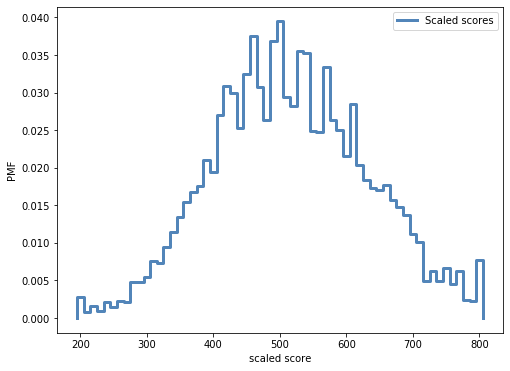

In [7]:
thinkplot.Clf()
thinkplot.PrePlot(num=1)
thinkplot.Pmf(pmf)
thinkplot.Config(xlabel='scaled score',
                ylabel='PMF')

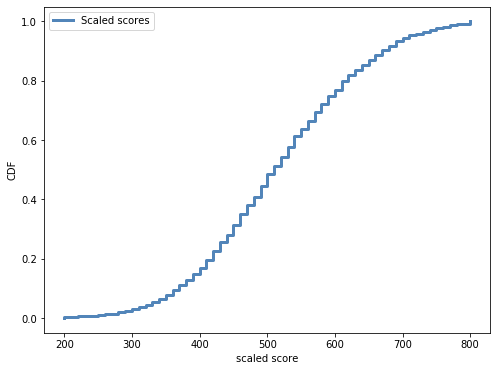

In [8]:
thinkplot.Clf()
thinkplot.PrePlot(num=1)
thinkplot.Cdf(pmf.MakeCdf())
thinkplot.Config(xlabel='scaled score',
                ylabel='CDF')

Let's get the distribution of the raw scores:

In [9]:
pmf_r = thinkbayes2.Pmf(label='raw')

for scaled, prob in pmf.Items():
    
    raw = mapping.Reverse(scaled)
    
    pmf_r.Incr(raw, prob)

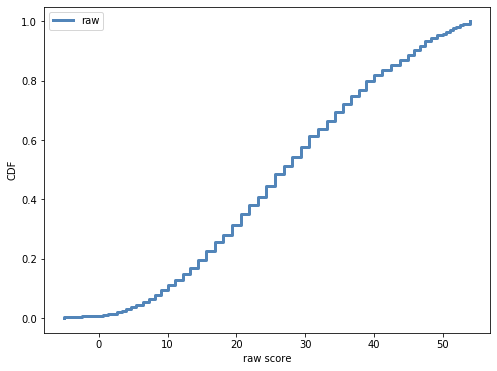

In [10]:
thinkplot.Clf()
thinkplot.PrePlot(num=1)
thinkplot.Cdf(pmf_r.MakeCdf())
thinkplot.Config(xlabel='raw score',
                ylabel='CDF')

In [11]:
max_score = max( pmf_r.Values() )
print('max raw score:', max_score)

max raw score: 54


Let's get the prior on `p_correct`

In [12]:
pmf_p = thinkbayes2.Pmf()

for raw, prob in pmf_r.Items():
    
    pmf_p.Incr( raw/max_score, prob)

No handles with labels found to put in legend.


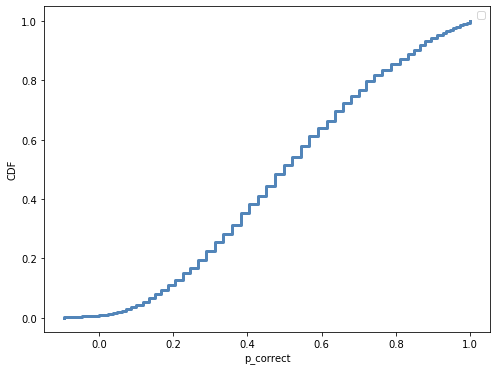

In [13]:
thinkplot.Clf()
thinkplot.PrePlot(num=1)
thinkplot.Cdf(pmf_p.MakeCdf())
thinkplot.Config(xlabel='p_correct',
                ylabel='CDF')

All of this is done in the `Exam` class in `sat.py`. For the sake of the exercise (and not to have conficting paths) I redo things here. The `Exam` class contains the all the info about the exam: distribution of raw/scaled score, max score and the prior on `p_correct`.

In [14]:
class Exam(object):
    '''
    handles exam data
    '''
    
    def __init__(self, scaleFileName='/Users/francesco/PersonalProjects/ThinkBayes2/data/sat_scale.csv', rankFileName='/Users/francesco/PersonalProjects/ThinkBayes2/data/sat_ranks.csv'):
        
        ### read the file and create the mapping
        self.scale = sat.ReadScale(scaleFileName)
        
        ### read the distribution of the scaled scores
        scores = sat.ReadRanks(rankFileName)
        pmf_score = thinkbayes2.MakePmfFromDict(dict(scores), label='scaled scores')
        
        ### get the distribution of raw scores
        self.pmf_raw = self.ReverseScale(pmf_score)
        
        self.max_score = max( self.pmf_raw.Values() )
        
        ### get the prior on p_correct
        self.prior = sat.DivideValues(self.pmf_raw, self.max_score)
    
    def ReverseScale(self, pmf):
        '''
        apply the reverse mapping to the pmf of scaled scores
        --> return the pmf of raw scores
        '''
        
        pmf_out = thinkbayes2.Pmf()
        
        for scaled, prob in pmf.Items():
            raw = self.Reverse(scaled)
            
            pmf_out.Incr(raw, prob)
            
        return pmf_out
    
    def Reverse(self, score):
        """Looks up a scaled score and returns a raw score.
        Since we ignore the penalty, negative scores round up to zero.
        """
        
        raw = self.scale.Reverse(score)
        return raw if raw > 0 else 0

In [15]:
ex = Exam()

No handles with labels found to put in legend.


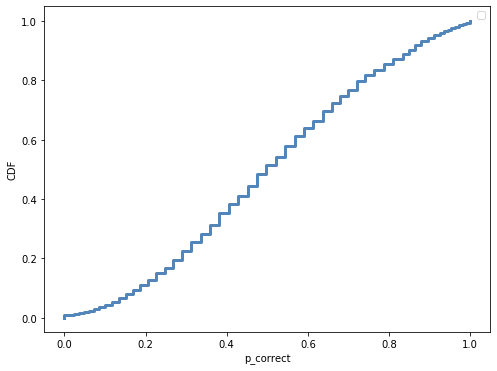

In [16]:
thinkplot.Clf()
thinkplot.PrePlot(num=1)
thinkplot.Cdf(ex.prior.MakeCdf())
thinkplot.Config(xlabel='p_correct',
                ylabel='CDF')

**note**: the distribution of the number of correct answers goes directly into the prior distribution of `p_correct`.

Now it's time to take care of the test-takers. This is done through a dedicated class which is a `Suite` of hypotheses representing the values of `p_correct`. This class has to be aware of the `Exam` class (e.g. to get the prior of `p_correct`) and about the score (so that it can compute the likelihood).

How do we compute the likelihood, i.e. P(`score`|`p_correct`)? There are two aspects to take into account:  
1) a further simplification: let's ingnore the penalty due to wrong answers. In this way the raw score is simply the number of positive outcomes out of `n` attempts with probability `p_correct`. In this frame `n` is the total number of questions  
2) the score we provide is the scaled score, so it has to be reversed to raw score before making the computation at the previous point

In [17]:
class Sat(thinkbayes2.Suite):
    
    def __init__(self, exam, score, label=None):
        
        self.exam = exam
        self.score = score
        
        thinkbayes2.Suite.__init__(self, exam.prior, label=label)
        
        ## copy the prior
        #for p_correct, prob in exam.prior.Items():
        #    self.Set(p_correct, prob)
        
        ## update the prior with the score
        self.Update(score)
    
    def Likelihood(self, data, hypo):
        '''
        compute the likelihood. Since the process is approximated with a Binomial, negative values are rounded to 0
        '''
        score = data
        p_correct = hypo
        
        k = self.exam.Reverse(score)
        n = self.exam.max_score
        
        
        like = thinkbayes2.EvalBinomialPmf(k, n, p_correct)
        
        return like if like > 0 else 0

In [18]:
Alice = Sat(Exam(), 780, label='Alice')
Bob = Sat(Exam(), 740, label='Bob')

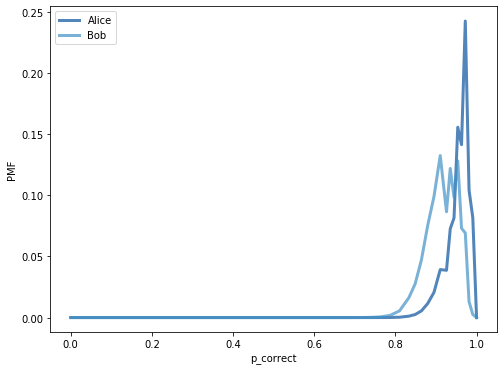

In [19]:
thinkplot.Clf()
thinkplot.PrePlot(num=2)
thinkplot.Pdfs([Alice, Bob])
thinkplot.Config(xlabel='p_correct',
                ylabel='PMF')

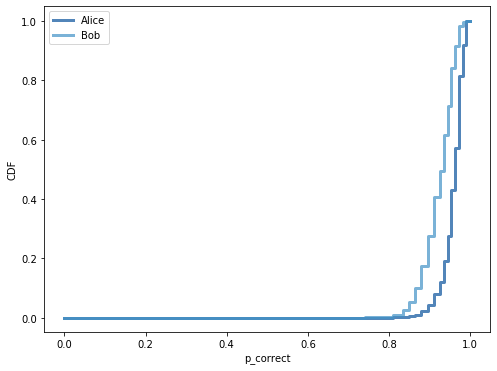

In [20]:
thinkplot.Clf()
thinkplot.PrePlot(num=2)
thinkplot.Cdfs([Alice.MakeCdf(), Bob.MakeCdf()])
thinkplot.Config(xlabel='p_correct',
                ylabel='CDF')

Now that we have the posterior distributions of `p_correct` for both Bob and Alice, we can try to answer the orginal question: "How strong is the evidence that Alice is better prepared than Bob?"

Let's define two different hypotheses:
* A: Alice is more prepared than Bob, i.e. Alice's `p_correct` is greater than Bob's
* B: Bob is more prepared than Alice, i.e. vice versa of the above

To evaluate the two hypotheses, the two distributions have to be compared, i.e. what is the probability that Alice's `p_correct` is greater than Bob's? This can be easily computed with `thinkbayes2.PmfProbGreater(...)`. In this particular case, since we are dealing with discrete values, the possibility of the two `p_correct`-s being equal has to be handled.

There is one crucial aspect which is worth stressing: in the first part of the exercise the hypotheses where the values of `p_correct` and the data were the test scores. We were wondering something like: given the test score, what is the value of `p_correct` for any test-taker?

On the other hand now we are considering a different set of hypotheses: A and B, defined above. Now we are asking: given the (posterior) distributions of `p_correct`, who is the best student? In this context, the posterior distributions of `p_correct` are the data we use to update our beliefs on who is the best student.

We start with uniform prior, i.e. P(A) = P(B) = 0.5, and we update them with the data. In particular the likelihood is now given by:
P(Data|A), where "Data" is the pair of `p_correct` distributions, and A (or B) select the cases in which one of the two `p_correct`-s is greater than the other, so:
* P(Data|A) = P( "Alice's `p_correct` > Bob's `p_correct`" )
* P(Data|B) = P( "Bob's `p_correct` > Alice's `p_correct`" )

In [21]:
class TopLevel(thinkbayes2.Suite):
    
    def Update(self, data):
        
        a_sat, b_sat = data
        
        a_like = thinkbayes2.PmfProbGreater(a_sat, b_sat)
        b_like = thinkbayes2.PmfProbGreater(b_sat, a_sat)
        c_like = thinkbayes2.PmfProbEqual(a_sat, b_sat)
        
        a_like += c_like / 2
        b_like += c_like / 2
        
        self.Mult('A', a_like)
        self.Mult('B', b_like)
        
        self.Normalize()

In [22]:
compare = TopLevel('AB')

In [23]:
compare

TopLevel({'A': 0.5, 'B': 0.5})

`TopLevel` is a `Suite` so it is initialized to have a uniform prior by default. Here "prior" means the probabilities of each hypothesis.

In [24]:
compare.Update((Alice, Bob))

In [25]:
compare

TopLevel({'A': 0.7931232450413125, 'B': 0.2068767549586875})

The Bayes Factor is given by the ratio of the two likelihoods.

In [26]:
print('likelihood ratio A/B:', compare.Prob('A')/compare.Prob('B'))

likelihood ratio A/B: 3.8337958520264697


## Scenario 2
Now improve the model: the questions in the test are not assumed to be equally hard. So, while in the previous scenario the probability that a given test taker would answer correctly to one of the question was called `p_correct` and this was basically the metric used to evaluate the how good a student was, now things get more complicated:
* each test-taker has some degree of `efficacy`, i.e. their ability to answer SAT questions.
* each question has some level of `difficulty`
* the chance that a test-taker gives the right answer to a question is: P = $\frac{1}{(1 + e^{-a*(\textrm{efficacy} - \textrm{difficulty})})}$

The formula in the last bullet comes from "item response theory" and we take it for good -- is it not actually the point of the study. Anyway it is already included in `sat.ProbCorrect(...)`.

If we know the distributions of `efficacy` for the test takers and `difficulty` for the questions we can compute the distribution of the raw score. This is done in two steps:

**Step1**: for a given test taker (i.e. for a given `efficacy`) and a given set of questions (i.e. a given distribution of `difficulties`) compute the distribution of the raw score:

In [27]:
def PmfCorrect(efficacy, difficulties, func=sat.BinaryPmf):
    
    ## default for the sum
    pmf0 = thinkbayes2.Pmf([0])
    
    ## get the probabilities of correct answer
    ps = [ sat.ProbCorrect(efficacy, diff) for diff in difficulties ]
    
    ## build a pmf of correct-incorrect
    pmfs = [ func(p) for p in ps ]
    
    ## build the final distribution
    dist = sum(pmfs, pmf0)
    
    return dist

Example:

In [28]:
eff = 0.5
difficulties = 0.7 * np.ones(54)
out = PmfCorrect(eff, difficulties)

No handles with labels found to put in legend.


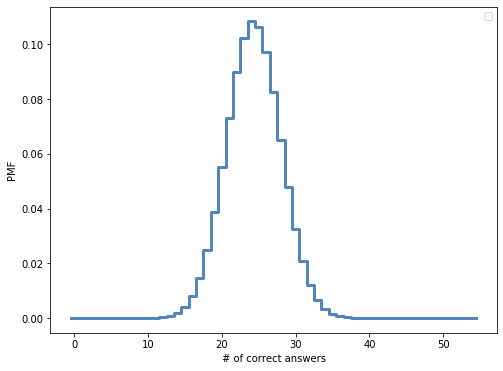

In [29]:
thinkplot.Clf()
thinkplot.PrePlot(num=1)
thinkplot.Pmf(out)
thinkplot.Config(xlabel='# of correct answers',
                ylabel='PMF')

**Step 2**: if we know a person's `efficacy` we can compute the distribution of correct answers (i.e. the raw score). For a bunch of people, i.e. for a distribution of `efficacies`, the distribution of correct answers is a mixture.

In [30]:
def MakeRawScoreDist(efficacies, difficulties, func=sat.BinaryPmf):
    
    pmfs = thinkbayes2.Pmf()
    
    for eff, prob in efficacies.Items():
        scores = PmfCorrect(eff, difficulties, func=func)
        
        pmfs.Set(scores, prob)
        
    mix = thinkbayes2.MakeMixture(pmfs)
    return mix

What distributions to use for `efficacies` and `difficulties`? In the book it is assumed that `efficacies` is Gaussian with mean 0 and sigma 1.5.

A few comments on this choice: first of all, as mentioned above, what counts is the difference between `efficacy` and `difficulty` so the absolute scale of the `efficacies` is not important (as long as `difficulties` have a compatible scale -- see later). Also, I guess this assumption is kind of mimicking that the "goodness" of the students (modelled here with the `efficacy`) is distributed with a Gaussian, which is a reasonable assumption.

The distribution of `difficulties` is assumed to be uniform. Not sure where this comes from :\
Anyway, let's follow this. Now the parameters of the distribution (center and width) have to be found. Here the data are used: if we knew the distribution of `difficulties` we could have obtained the distribution of the correct answers, but here we have the inverse problem, we have the distribution of the answers and we have to find the distribution of `difficulties`.

From the above, in our model:  
`# of correct answers` = F(`efficacies`, `difficulties`)  
in which we know the `# of correct answers` from the data, the distribution of `efficacies` is assumed to be Gaussian and we have assumed the shape of the distribution of `difficulties`. So by trial and error we can find the distribution of `difficulties` by giving as input some values, producin the "expected" # of correct answers and comparing it to the real one. This is how the model is calibrated.

In [31]:
efficacies = thinkbayes2.MakeNormalPmf(0, 1.5, 3)

def ComputeExpectedScore(center, width, eff_distr, n=54, label=None, func=sat.BinaryPmf):
    '''
    Compute the pmf of the expected score for the n questions
    '''
    
    diff_distr = np.linspace(center-width, center+width, n)
    
    pmf_correct = MakeRawScoreDist(eff_distr, diff_distr, func=func)
    pmf_correct.label = label
    
    return pmf_correct

In [32]:
values = [
    (1, 2),
    (0, 5),
    (-1, 1),
    (-0.05, 1.8)
]

test_pmfs = []

for value in values:
    center, width = value
    
    test_pmfs.append( ComputeExpectedScore(center, width, efficacies, label=f'c = {center} w = {width}') )
    

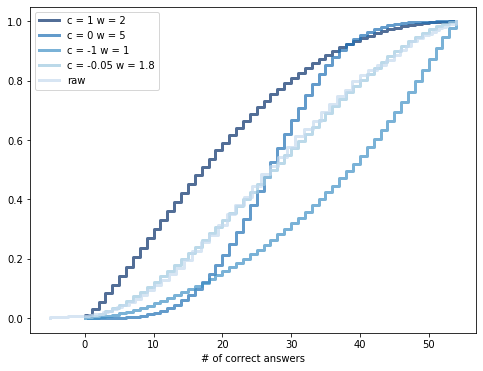

In [33]:
thinkplot.Clf()
thinkplot.PrePlot(num=len(test_pmfs)+1)
thinkplot.Cdfs( [ pmf.MakeCdf() for pmf in test_pmfs ] + [pmf_r.MakeCdf()] )
thinkplot.Config(xlabel='# of correct answers')

The parameters proposed in the book provide indeed a good approximation. For a better understanding, print a few values of the probability of giving a correct answers for a few combinations of `efficacy` and `difficulty`

In [34]:
efficacies = [3, 1.5, 0, -1.5, -3]
difficulties = [-1.8, 0, 1.8]

for eff in efficacies:
    for diff in difficulties:
        print(f'efficacy = {eff} difficulty = {diff} --> ProbCorrect = {sat.ProbCorrect(eff, diff)}')

efficacy = 3 difficulty = -1.8 --> ProbCorrect = 0.9918374288468401
efficacy = 3 difficulty = 0 --> ProbCorrect = 0.9525741268224334
efficacy = 3 difficulty = 1.8 --> ProbCorrect = 0.7685247834990175
efficacy = 1.5 difficulty = -1.8 --> ProbCorrect = 0.9644288107273639
efficacy = 1.5 difficulty = 0 --> ProbCorrect = 0.8175744761936437
efficacy = 1.5 difficulty = 1.8 --> ProbCorrect = 0.425557483188341
efficacy = 0 difficulty = -1.8 --> ProbCorrect = 0.8581489350995123
efficacy = 0 difficulty = 0 --> ProbCorrect = 0.5
efficacy = 0 difficulty = 1.8 --> ProbCorrect = 0.14185106490048777
efficacy = -1.5 difficulty = -1.8 --> ProbCorrect = 0.574442516811659
efficacy = -1.5 difficulty = 0 --> ProbCorrect = 0.18242552380635635
efficacy = -1.5 difficulty = 1.8 --> ProbCorrect = 0.03557118927263618
efficacy = -3 difficulty = -1.8 --> ProbCorrect = 0.23147521650098238
efficacy = -3 difficulty = 0 --> ProbCorrect = 0.04742587317756678
efficacy = -3 difficulty = 1.8 --> ProbCorrect = 0.00816257115

**note**: while in the simplified scenario the "historic" data about the score were simply used to build the distribution of `p_correct`, here things are very different: in short the equivalent of `p_correct` is given by the combination of the `efficacy` and `difficulty`, the former is assumed to have a known shape and therefore from the historic data we gain knowledge about the difficulty.

Because of the above it is natural to extend the `Exam` class from the previous scenario to contain these updates. In this new scenarion, the `Exam2` class will again contain all the info about the exam: distribution of raw/scaled score, max score and the distributions of `efficacy` and `difficulty`. 

In [35]:
class Exam2(object):
    '''
    handles exam data in scenario 2
    '''
    
    def __init__(self, scaleFileName='/Users/francesco/PersonalProjects/ThinkBayes2/data/sat_scale.csv', rankFileName='/Users/francesco/PersonalProjects/ThinkBayes2/data/sat_ranks.csv'):
        
        ### read the file and create the mapping
        self.scale = sat.ReadScale(scaleFileName)
        
        ### read the distribution of the scaled scores
        scores = sat.ReadRanks(rankFileName)
        pmf_score = thinkbayes2.MakePmfFromDict(dict(scores), label='scaled scores')
        
        ### get the distribution of raw scores
        self.pmf_raw = self.ReverseScale(pmf_score)
        
        self.max_score = max( self.pmf_raw.Values() )
        
        ### distribution of difficulties
        center = -0.05
        width = 1.8
        self.difficulties = np.linspace(center-width, center+width, self.max_score)
    
    def ReverseScale(self, pmf):
        '''
        apply the reverse mapping to the pmf of scaled scores
        --> return the pmf of raw scores
        '''
        
        pmf_out = thinkbayes2.Pmf()
        
        for scaled, prob in pmf.Items():
            raw = self.Reverse(scaled)
            
            pmf_out.Incr(raw, prob)
            
        return pmf_out
    
    def Reverse(self, score):
        """Looks up a scaled score and returns a raw score.
        Since we ignore the penalty, negative scores round up to zero.
        """
        
        raw = self.scale.Reverse(score)
        return raw if raw > 0 else 0

Correspondingly, a new `Sat` class is needed to handle the individual test takers in the new scenario. It contains the prior on the `efficacy` and the new likelihood.

In [38]:
class Sat2(thinkbayes2.Suite):
    
    def __init__(self, exam, score, func=sat.BinaryPmf, label=None):
        
        self.exam = exam
        self.score = score
        
        mu = 0
        sigma = 1.5
        efficacies = thinkbayes2.MakeNormalPmf(mu, sigma, 3)
        thinkbayes2.Suite.__init__(self, efficacies, label=label)
        
        self.func = func
        
        ## update the prior with the score
        self.Update(score)
    
    def Likelihood(self, data, hypo):
        '''
        compute the likelihood. Since the process is approximated with a Binomial, negative values are rounded to 0
        '''
        score = data
        efficacy = hypo
        
        pmf = PmfCorrect(efficacy, self.exam.difficulties, func=self.func)
        raw = self.exam.Reverse(score)
        
        like = pmf.Prob(raw)
        return like if like > 0 else 0

Now use the data and check the result

In [39]:
Alice2 = Sat2(Exam2(), 780, label='Alice')
Bob2 = Sat2(Exam2(), 740, label='Bob')

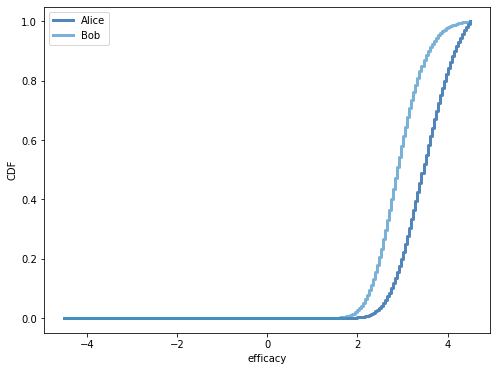

In [40]:
thinkplot.Clf()
thinkplot.PrePlot(num=2)
thinkplot.Cdfs([Alice2.MakeCdf(), Bob2.MakeCdf()])
thinkplot.Config(xlabel='efficacy',
                ylabel='CDF')

In [41]:
compare2 = TopLevel('AB')

In [42]:
compare2.Update((Alice2, Bob2))

In [43]:
compare2

TopLevel({'A': 0.7710486797735883, 'B': 0.22895132022641182})

In [44]:
print('BF in scenario 2:', compare2.Prob('A')/compare2.Prob('B'))

BF in scenario 2: 3.367740701434226


The result is very similar to scenario 1 in terms of BF on the `efficacy` (while before it was on `p_correct`).

As a further step, predict the results of a second test that Alice and Bob might take. Let's do this with the following steps:  
1) use the posterior distributions of the `efficacy` for both Alice and Bob to compute the expected distribution of raw scores  
2) compare the results

In [45]:
exam = Exam2()
Alice_pred = MakeRawScoreDist(Alice2, exam.difficulties)
Bob_pred = MakeRawScoreDist(Bob2, exam.difficulties)

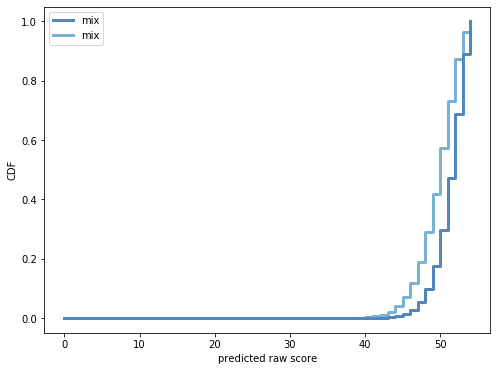

In [46]:
thinkplot.Clf()
thinkplot.PrePlot(num=2)
thinkplot.Cdfs([Alice_pred.MakeCdf(), Bob_pred.MakeCdf()])
thinkplot.Config(xlabel='predicted raw score',
                ylabel='CDF')

In [47]:
compare_pred = TopLevel('AB')

In [48]:
compare_pred.Update((Alice_pred, Bob_pred))

In [49]:
compare_pred

TopLevel({'A': 0.6847425766927546, 'B': 0.3152574233072454})

In [50]:
print('BF on the predicted exam scores:', compare_pred.Prob('A')/compare_pred.Prob('B'))

BF on the predicted exam scores: 2.172010953808419


## Scenario 3
What if, instead of considering only the points for the correct answers, we consider also the penalites for the wrong answers?

In scenario 2 things were done as follows:  
1) for a given `efficacy` and `difficulty` pair the probability of giving the correct answer was computed `ProbCorrect`  
2) `ProbCorrect` was used to compute the binary PMF for the single question with `sat.BinaryPmf(...)`. Assuming the raw score to be the same as the number of correct answers, the binary PMF has only values 0 and 1.
3) The pmfs for all the questions were summed together

Given this setup, the only aspect that needs to be changed is how the binary pmf was computed. In particular here we can compute the total raw score instead of the number of correct answers:

In [51]:
def BinaryPmfWithPenalty(p, penalty=-0.25):
    
    pmf = thinkbayes2.Pmf()
    pmf.Set(1, p)
    pmf.Set(penalty, 1-p)
    
    return pmf

In [52]:
eff = 0.5
difficulties = 0.7 * np.ones(54)
out = PmfCorrect(eff, difficulties, func=BinaryPmfWithPenalty)

No handles with labels found to put in legend.


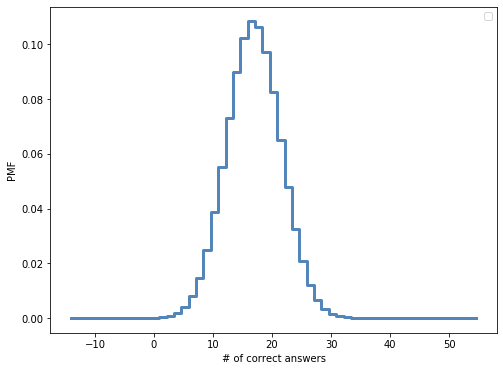

In [53]:
thinkplot.Clf()
thinkplot.PrePlot(num=1)
thinkplot.Pmf(out)
thinkplot.Config(xlabel='# of correct answers',
                ylabel='PMF')

Let's recalibrate the difficulties

In [54]:
efficacies = thinkbayes2.MakeNormalPmf(0, 1.5, 3)

values = [
    (-.8, 3.2),
    (0, 5),
    (-1, 1),
    (-0.05, 1.8)
]

test_pmfs = []

for value in values:
    center, width = value
    
    test_pmfs.append( ComputeExpectedScore(center, width, efficacies, label=f'c = {center} w = {width}', func=BinaryPmfWithPenalty) )
    

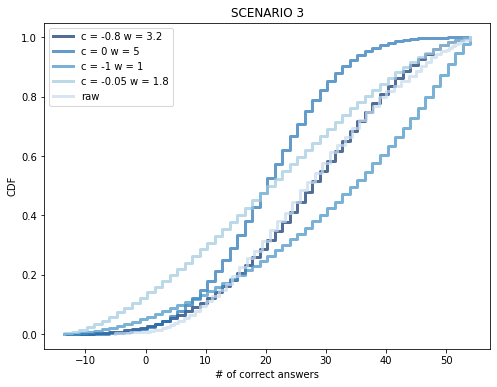

In [55]:
thinkplot.Clf()
thinkplot.PrePlot(num=len(test_pmfs)+1)
thinkplot.Cdfs( [ pmf.MakeCdf() for pmf in test_pmfs ] + [pmf_r.MakeCdf()] )
thinkplot.Config(xlabel='# of correct answers',
                ylabel='CDF',
                title='SCENARIO 3')

center = -0.8 and width = 3.2 seems like a good approximation

In [56]:
center = -0.8
width = 3.2

In [57]:
class Exam3(object):
    '''
    handles exam data in scenario 2
    '''
    
    def __init__(self, center, width, scaleFileName='/Users/francesco/PersonalProjects/ThinkBayes2/data/sat_scale.csv', rankFileName='/Users/francesco/PersonalProjects/ThinkBayes2/data/sat_ranks.csv'):
        
        ### read the file and create the mapping
        self.scale = sat.ReadScale(scaleFileName)
        
        ### read the distribution of the scaled scores
        scores = sat.ReadRanks(rankFileName)
        pmf_score = thinkbayes2.MakePmfFromDict(dict(scores), label='scaled scores')
        
        ### get the distribution of raw scores
        self.pmf_raw = self.ReverseScale(pmf_score)
        
        self.max_score = max( self.pmf_raw.Values() )
        
        ### distribution of difficulties
        self.difficulties = np.linspace(center-width, center+width, self.max_score)
    
    def ReverseScale(self, pmf):
        '''
        apply the reverse mapping to the pmf of scaled scores
        --> return the pmf of raw scores
        '''
        
        pmf_out = thinkbayes2.Pmf()
        
        for scaled, prob in pmf.Items():
            raw = self.Reverse(scaled)
            
            pmf_out.Incr(raw, prob)
            
        return pmf_out
    
    def Reverse(self, score):
        """Looks up a scaled score and returns a raw score.
        Since we ignore the penalty, negative scores round up to zero.
        """
        
        raw = self.scale.Reverse(score)
        #return raw if raw > 0 else 0
        return raw

For the new `Sat` class a small hack is needed due to the fact that the raw score is not the number of correct answers anymore. On the one hand the outcome of `Exam.Reverse(...)` is the number of correct answers, while the outcome of `PmfCorrect(...)` is a raw score taking into account the penalties (e.g. for an exam with 53 correct answers and 1 wrong answer the score is 52.75). This mismatch is taken care of inside the `Likelihood(...)` method.

In [59]:
class Sat3(thinkbayes2.Suite):
    
    def __init__(self, exam, score, func=sat.BinaryPmf, label=None):
        
        self.exam = exam
        self.score = score
        
        mu = 0
        sigma = 1.5
        efficacies = thinkbayes2.MakeNormalPmf(mu, sigma, 3)
        thinkbayes2.Suite.__init__(self, efficacies, label=label)
        
        self.func = func
        
        ## update the prior with the score
        self.Update(score)
    
    def Likelihood(self, data, hypo):
        '''
        compute the likelihood. Since the process is approximated with a Binomial, negative values are rounded to 0
        '''
        score = data
        efficacy = hypo
        
        pmf = PmfCorrect(efficacy, self.exam.difficulties, func=self.func)
        raw = self.exam.Reverse(score)
        
        ### hack to che the proper values in pmf, since now raw score != number of correct answers
        raw = min(list(pmf.Values()), key=lambda x:abs(x-raw))
        
        like = pmf.Prob(raw)
        
        #return like if like > 0 else 0
        return like

In [60]:
exam = Exam3(center, width)
Alice3 = Sat3(exam, 780, func=BinaryPmfWithPenalty, label='Alice')
Bob3 = Sat3(exam, 740, func=BinaryPmfWithPenalty, label='Bob')

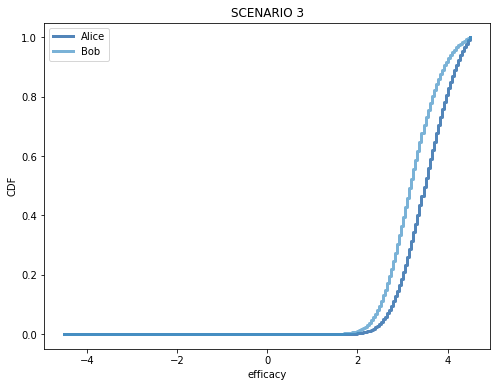

In [61]:
thinkplot.Clf()
thinkplot.PrePlot(num=2)
thinkplot.Cdfs([Alice3.MakeCdf(), Bob3.MakeCdf()])
thinkplot.Config(xlabel='efficacy',
                ylabel='CDF',
                title='SCENARIO 3')

In [62]:
compare3 = TopLevel('AB')

In [63]:
compare3.Update((Alice3, Bob3))

In [64]:
compare3

TopLevel({'A': 0.6487922848769326, 'B': 0.3512077151230674})

In [65]:
print('BF:', compare3.Prob('A')/compare3.Prob('B'))

BF: 1.8473178604564195
